# Setting up Gpu

In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


# Imports

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/dev/null'
import warnings
warnings.filterwarnings("ignore", message="No artists with labels found to put in legend.") 
warnings.filterwarnings("ignore", category=FutureWarning)
import cv2
import os
import pathlib
import random
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_gan as tfgan
from tensorflow.keras.applications import VGG16
from keras.layers import Conv2D, Conv2DTranspose, Dropout, Dense, Reshape, LayerNormalization, LeakyReLU
from keras import layers, models
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics.pairwise import polynomial_kernel
from scipy.linalg import sqrtm
SEED = 24
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
tf.__version__

'2.13.0'

# Loading Data

In [4]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels

In [5]:
readDatasetObject = ReadDataset('/tf/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()

In [6]:
images.shape, labels.shape

((5216, 64, 64, 1), (5216,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


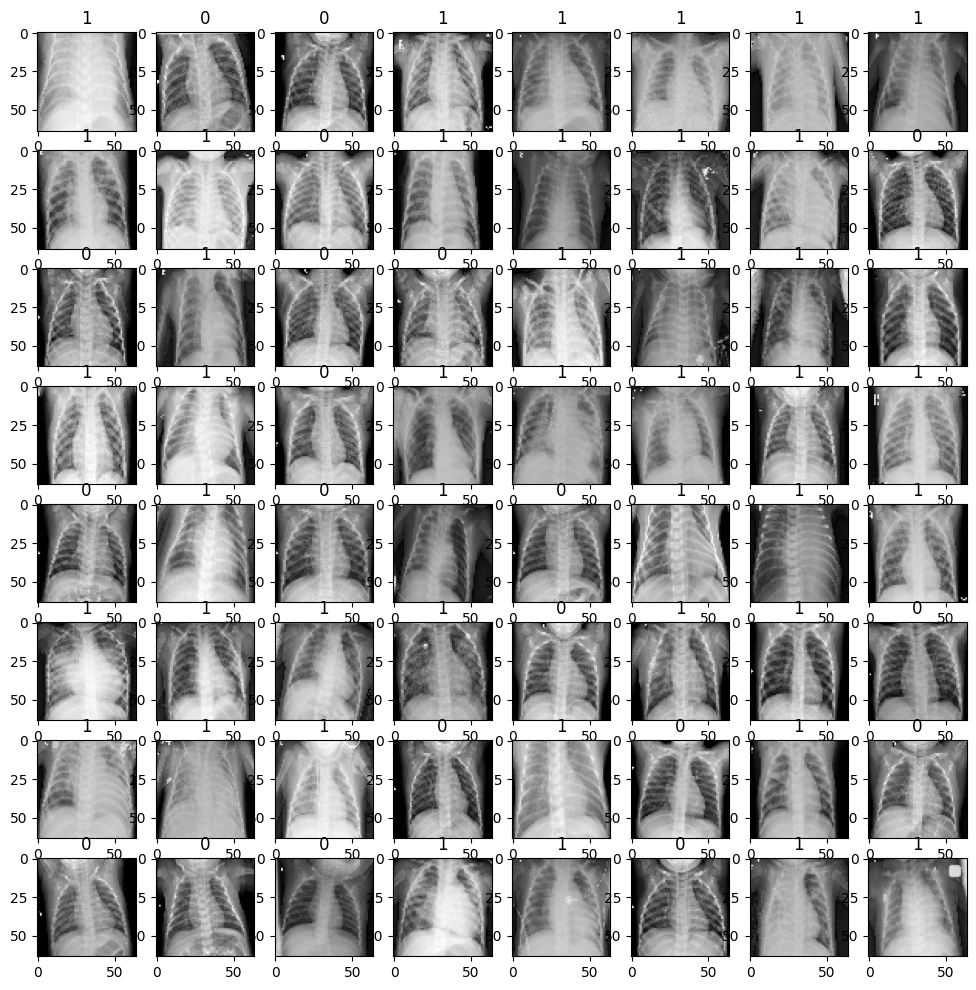

In [7]:
plt.figure(figsize = (12, 12))
indexs = np.random.randint(0, len(labels), size = (64, ))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[indexs[i]], cmap='gray')
    plt.title(labels[indexs[i]])
plt.legend()

# Defining the GAN module

In [8]:
class Acgan:
    def __init__(self, eta, batch_size, epochs, weight_decay, latent_space,
                 image_shape, kernel_size, label_smoothing=0.9):
        self.eta = eta
        self.batch_size = batch_size
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.latent_space = latent_space
        self.image_shape = image_shape
        self.kernel_size = kernel_size
        self.label_smoothing = label_smoothing

    def data(self, images, labels):
        ytrain = tf.keras.utils.to_categorical(labels)
        self.images = images
        self.labels = ytrain

    def samples(self, G, noize, labels):
        images = G.predict([noize, labels])
        ys = np.argmax(labels, axis=1)
        plt.figure(figsize=(12, 4))
        for i in range(16):
            plt.subplot(2, 8, (i + 1))
            plt.imshow(images[i], cmap='gray')
            plt.title(ys[i])
        plt.show()


    def generator(self, inputs, labels):
        filters = [256, 128, 64, 32]
        padding = 'same'
        x = inputs
        y = labels
        x = layers.concatenate([x, y])
        x = layers.Dense(2048)(x)
        x = layers.Dense(8*8*filters[0], kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        x = layers.Reshape((8, 8, filters[0]))(x)
        for filter in filters:
            if filter >= 64:
                strides = 2
            else:
                strides = 1
            x = layers.LayerNormalization()(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = Conv2DTranspose(filter, kernel_size=self.kernel_size, padding=padding, strides=strides)(x)
        x = Conv2DTranspose(1, kernel_size=self.kernel_size, padding=padding)(x)
        x = layers.Activation('sigmoid')(x)
        self.generatorModel = models.Model(inputs=[inputs, labels], outputs=x, name='generator')

    def discriminator(self, inputs):
        x = inputs
        filters = [32, 64, 128, 256]
        padding = 'same'
        for filter in filters:
            if filter < 256:
                strides = 2
            else:
                strides = 1
            x = Conv2D(filter, kernel_size=self.kernel_size, padding=padding, strides=strides,
                      kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
            x = LeakyReLU(alpha=0.2)(x)
        x = layers.Flatten()(x)
        outputs = Dense(1)(x)
        labelsOutput = Dense(256, kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
        labelsOutput = Dropout(0.3)(labelsOutput)
        labelsOutput = Dense(2)(labelsOutput)
        labelsOutput = layers.Activation('softmax')(labelsOutput)
        self.discriminatorModel = models.Model(inputs=inputs, outputs=[outputs, labelsOutput], name='discriminator')

    def build(self):
        generatorInput = layers.Input(shape=(self.latent_space))
        discriminatorInput = layers.Input(shape=(self.image_shape))
        labelsInput = layers.Input(shape=(2,))
        self.generator(generatorInput, labelsInput)
        self.discriminator(discriminatorInput)
        G = self.generatorModel
        D = self.discriminatorModel
        D.compile(loss=['mse', 'binary_crossentropy'],
                 optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta, weight_decay=self.weight_decay))
        D.summary()
        G.summary()
        D.trainable = False
        GAN = models.Model(inputs=[generatorInput, labelsInput], outputs=D(G([generatorInput, labelsInput])))
        GAN.compile(loss=['mse', 'binary_crossentropy'],
                   optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.eta*0.5, weight_decay=self.weight_decay*0.5))
        GAN.summary()
        return G, D, GAN

    def save_model_weights(self, G, D, GAN, epoch):
        G.save_weights(f'generator_weights_epoch_{epoch}.h5')
        D.save_weights(f'discriminator_weights_epoch_{epoch}.h5')
        GAN.save_weights(f'gan_weights_epoch_{epoch}.h5')

    def load_model_weights(self, G, D, GAN, epoch):
        G.load_weights(f'generator_weights_epoch_{epoch}.h5')
        D.load_weights(f'discriminator_weights_epoch_{epoch}.h5')
        GAN.load_weights(f'gan_weights_epoch_{epoch}.h5')

    def trainAlgorithm(self, G, D, GAN):
        for epoch in range(self.epochs):
            indexs = np.random.randint(0, len(self.images), size=(self.batch_size,))
            realImages = self.images[indexs]
            realLabels = self.labels[indexs]
            realTag = tf.ones(shape=(self.batch_size,))*self.label_smoothing
            noize = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
            fakeLabels = tf.keras.utils.to_categorical(np.random.choice(range(2), size=(self.batch_size)), num_classes=2)
            fakeImages = G.predict([noize, fakeLabels], verbose=0)
            fakeTag = tf.zeros(shape=(self.batch_size,))
            allImages = np.vstack([realImages, fakeImages])
            allLabels = np.vstack([realLabels, fakeLabels])
            allTags = np.hstack([realTag, fakeTag])
            _, dlossTag, dlossLabels = D.train_on_batch(allImages, [allTags, allLabels])
            noize = tf.random.uniform(shape=(self.batch_size, self.latent_space), minval=-1, maxval=1)
            _, glossTag, glossLabels = GAN.train_on_batch([noize, fakeLabels], [realTag, fakeLabels])
            if epoch % 10000 == 0:
                print('Epoch: {}'.format(epoch))
                print('discriminator loss: [tag: {}, labels: {}], generator loss: [tag: {}, labels: {}]'.format(dlossTag, dlossLabels, glossTag, glossLabels))
                self.samples(G, noize, fakeLabels)
                # Save model weights
                self.save_model_weights(G, D, GAN, epoch)

# Instantiating the model

In [9]:
acgan = Acgan(eta = 0.0002, batch_size = 32, epochs = 62000, weight_decay = 6e-9,
              latent_space = 100, image_shape = (64, 64, 1), kernel_size = 5)

In [10]:
acgan.data(images, labels)

In [11]:
G, D, GAN = acgan.build()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           832       ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           51264     ['leaky_re_lu_4[0][0]']       
                                                                                      

# Training

Epoch: 0
discriminator loss: [tag: 0.43916577100753784, labels: 0.6902083158493042], generator loss: [tag: 0.2919501066207886, labels: 0.6859779357910156]
1/1 [==============================] - 0s 30ms/step


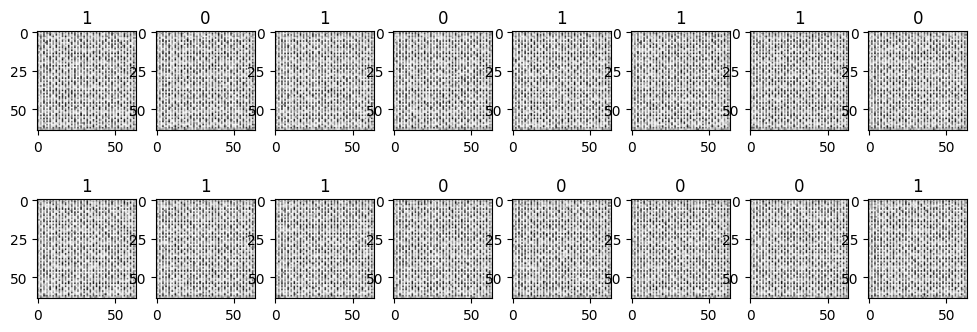

Epoch: 10000
discriminator loss: [tag: 0.18166983127593994, labels: 0.06302233040332794], generator loss: [tag: 0.2603861391544342, labels: 0.1544894576072693]
1/1 [==============================] - 0s 21ms/step


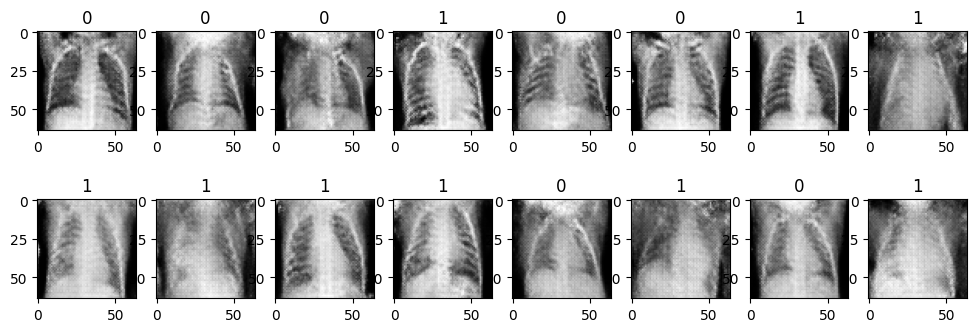

Epoch: 20000
discriminator loss: [tag: 0.1564965397119522, labels: 0.021811693906784058], generator loss: [tag: 0.43415796756744385, labels: 0.0008571955841034651]
1/1 [==============================] - 0s 134ms/step


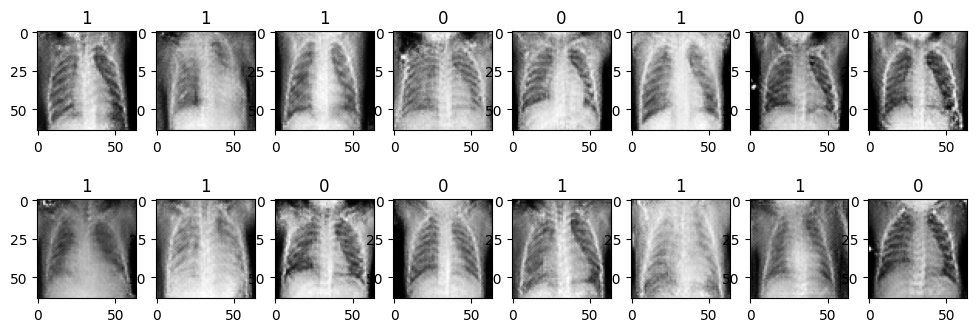

Epoch: 30000
discriminator loss: [tag: 0.14257439970970154, labels: 0.0013239572290331125], generator loss: [tag: 0.41131591796875, labels: 0.000692148576490581]
1/1 [==============================] - 0s 87ms/step


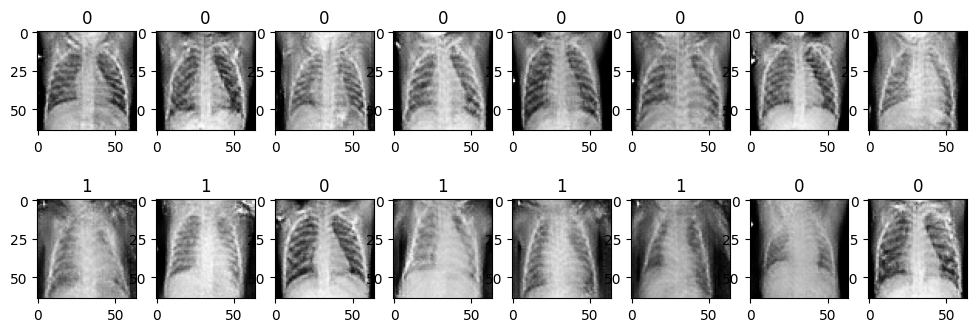

Epoch: 40000
discriminator loss: [tag: 0.08788008242845535, labels: 0.0005210193921811879], generator loss: [tag: 0.32901960611343384, labels: 0.017722906544804573]
1/1 [==============================] - 0s 21ms/step


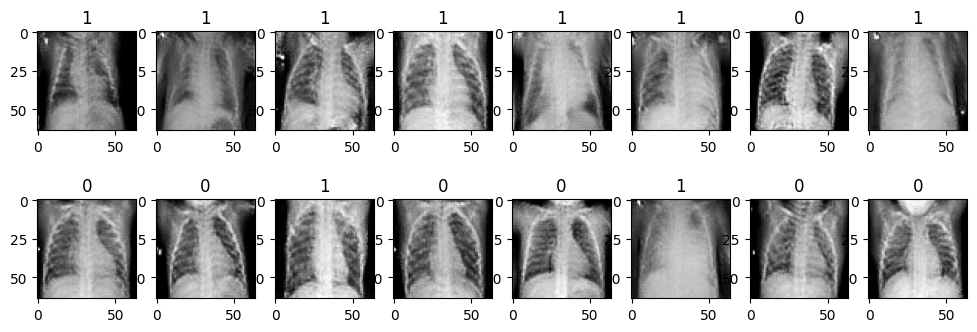

Epoch: 50000
discriminator loss: [tag: 0.09384356439113617, labels: 0.030653122812509537], generator loss: [tag: 0.639150083065033, labels: 0.0011360876960679889]
1/1 [==============================] - 0s 22ms/step


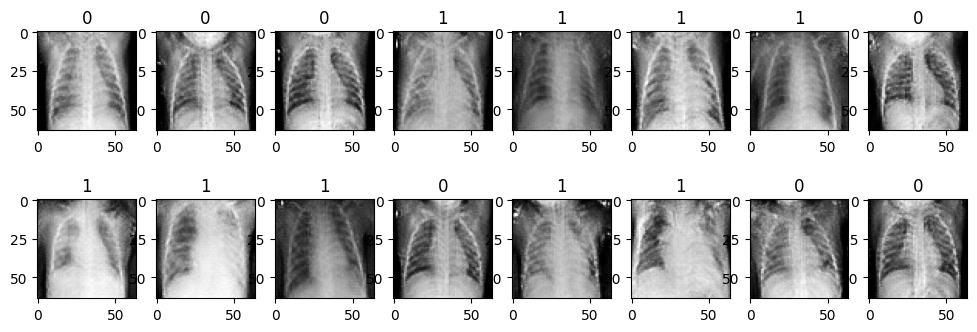

Epoch: 60000
discriminator loss: [tag: 0.08978946506977081, labels: 0.0005167846102267504], generator loss: [tag: 0.5128276348114014, labels: 7.42820993764326e-05]
1/1 [==============================] - 0s 72ms/step


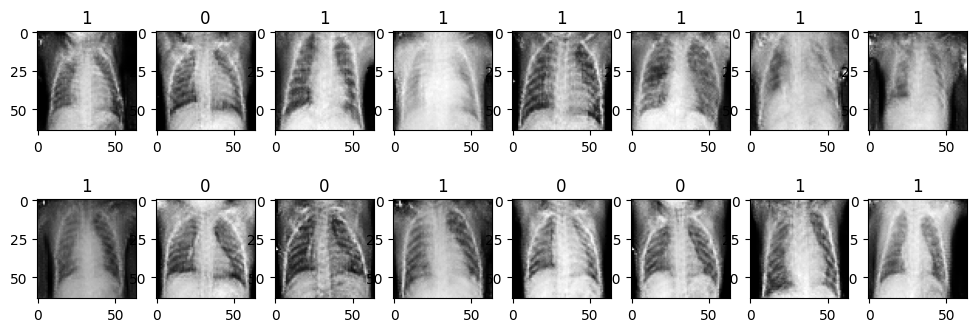

In [12]:
acgan.trainAlgorithm(G, D, GAN)

In [13]:
#G.save('/tf/Model/generator.h5')

In [14]:
#G = tf.keras.models.load_model('/tf/Model/generator.h5')

# Evaluation

In [15]:
def calculate_fid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)

    # Calculate the mean and covariance of the activations
    mu_real, sigma_real = np.mean(act_real, axis=0), np.cov(act_real, rowvar=False)
    mu_gen, sigma_gen = np.mean(act_gen, axis=0), np.cov(act_gen, rowvar=False)

    # Calculate FID score
    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))
    
    # Numerical error can occur in sqrtm, so check if the result is complex
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid


In [16]:
def calculate_kid(real_images, generated_images):
    # Load pre-trained VGG16 model
    vgg_model = VGG16(include_top=False, pooling='avg', input_shape=(64, 64, 3))
    
    # Get the activations from the model for real and generated images
    act_real = vgg_model.predict(real_images)
    act_gen = vgg_model.predict(generated_images)
    
    # Compute polynomial kernels
    kernel_real = polynomial_kernel(act_real)
    kernel_gen = polynomial_kernel(act_gen)
    kernel_cross = polynomial_kernel(act_real, act_gen)
    
    m = len(real_images)
    n = len(generated_images)
    
    # Calculate KID score
    kid = (np.sum(kernel_real) / (m * m)) + (np.sum(kernel_gen) / (n * n)) - (2 * np.sum(kernel_cross) / (m * n))
    return kid


In [17]:
def convert_grayscale_to_rgb(images):
    # Convert numpy array to TensorFlow tensor
    images_tensor = tf.convert_to_tensor(images)
    # Convert grayscale images to RGB
    return tf.image.grayscale_to_rgb(images_tensor)


In [18]:
datasetGenerationSize = 30000
noize = tf.random.uniform(shape = (datasetGenerationSize, 100), minval = -1, maxval = 1)
newlabels = tf.keras.utils.to_categorical(np.random.choice([0, 1], size = (datasetGenerationSize, )), num_classes = 2)

In [19]:
noize.shape, newlabels.shape

(TensorShape([30000, 100]), (30000, 2))

In [20]:
np.unique(np.argmax(newlabels, axis = 1), return_counts = True)

(array([0, 1]), array([14994, 15006]))

In [21]:
imagesGeneration = G.predict([noize, newlabels])
imagesGeneration.shape

938/938 [==============================] - 8s 9ms/step


(30000, 64, 64, 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


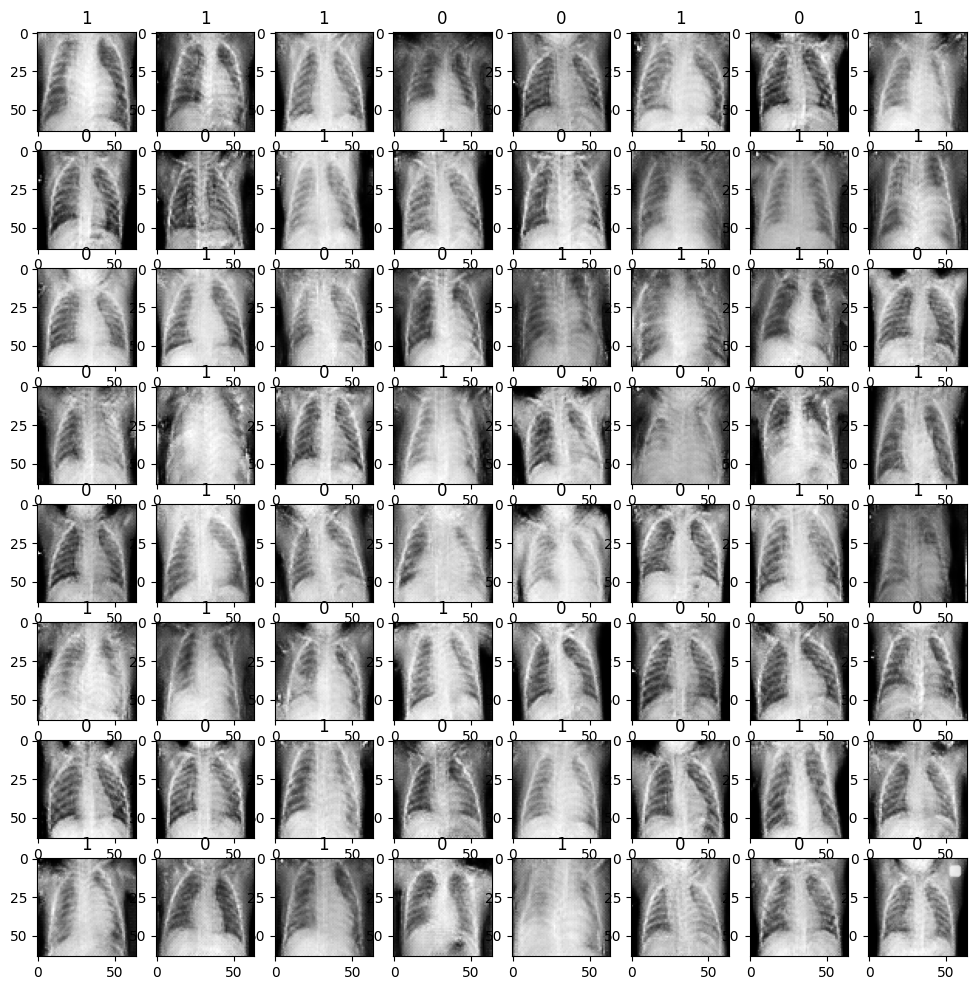

In [22]:
plt.figure(figsize = (12, 12))
t = np.argmax(newlabels, axis = 1)
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesGeneration[i],cmap='gray')
    plt.title(t[i])
plt.legend()

In [23]:
# Convert grayscale images to RGB
real_images_rgb = convert_grayscale_to_rgb(images)
generated_images_rgb = convert_grayscale_to_rgb(imagesGeneration)

# Calculate FID and KID scores
fid_score = calculate_fid(real_images_rgb, generated_images_rgb)
kid_score = calculate_kid(real_images_rgb, generated_images_rgb)

print(f'FID Score: {fid_score}')
print(f'KID Score: {kid_score}')


938/938 [==============================] - 5s 6ms/step
FID Score: 1.179064981136447
KID Score: 0.005236129695969538


In [24]:
# Using VGG16 with pre-trained weights for fine-tuning
basemodel = tf.keras.applications.VGG16(weights=None, input_shape=(64, 64, 1),
                                        pooling='max', include_top=False)
# Model architecture
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Assuming binary classification
m = tf.keras.models.Model(inputs=basemodel.input, outputs=x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [25]:
history = m.fit(imagesGeneration, np.argmax(newlabels, axis = 1),
                epochs = 60, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/60
375/375 [==============================] - 19s 33ms/step - loss: 0.2209 - val_loss: 0.5275
Epoch 2/60
375/375 [==============================] - 11s 29ms/step - loss: 0.0752 - val_loss: 0.0611
Epoch 3/60
375/375 [==============================] - 11s 29ms/step - loss: 0.0539 - val_loss: 0.0282
Epoch 4/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0441 - val_loss: 0.0187
Epoch 5/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0393 - val_loss: 0.0186
Epoch 6/60
375/375 [==============================] - 11s 29ms/step - loss: 0.0332 - val_loss: 0.0134
Epoch 7/60
375/375 [==============================] - 11s 29ms/step - loss: 0.0270 - val_loss: 0.0330
Epoch 8/60
375/375 [==============================] - 11s 29ms/step - loss: 0.0300 - val_loss: 0.0138
Epoch 9/60
375/375 [==============================] - 11s 30ms/step - loss: 0.0226 - val_loss: 0.0083
Epoch 10/60
375/375 [==============================] - 11s 29ms/step - loss: 0.018

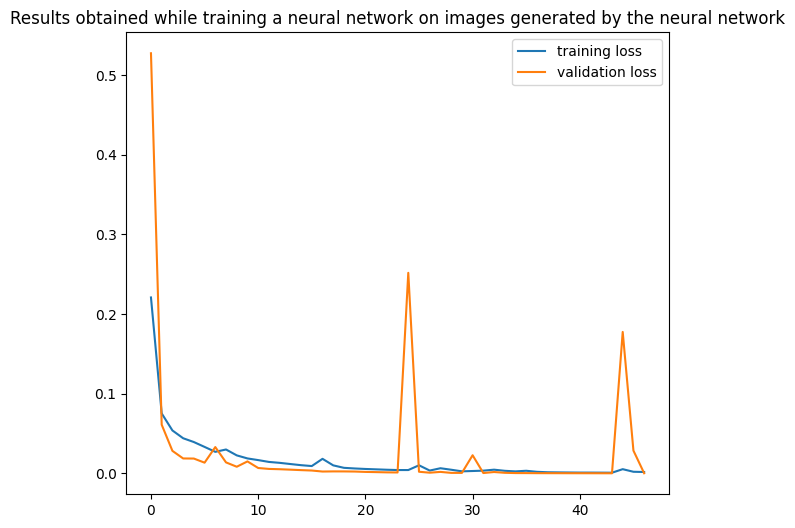

In [26]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [27]:
m.evaluate(images, labels)

163/163 [==============================] - 2s 9ms/step - loss: 0.7625


0.7624725699424744

In [28]:
y_pred = tf.squeeze(m.predict(images))
y_pred.shape

163/163 [==============================] - 1s 6ms/step


TensorShape([5216])

In [29]:
y_pred = y_pred >= 0.5
y_pred = np.array(y_pred, dtype = 'int32')
y_pred

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [30]:
accuracy_score(y_pred, labels)*100

86.579754601227

In [31]:
print(classification_report(y_pred, labels))

              precision    recall  f1-score   support

           0       0.99      0.66      0.79      2021
           1       0.82      1.00      0.90      3195

    accuracy                           0.87      5216
   macro avg       0.91      0.83      0.85      5216
weighted avg       0.89      0.87      0.86      5216



In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_pred, labels)
cm

array([[1331,  690],
       [  10, 3185]])

In [33]:
import pandas as pd
cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
cmObject.head()

,NORMAL,PNEUMONIA
NORMAL,1331,690
PNEUMONIA,10,3185


In [34]:
print('f1_score: {}, recall_score: {}, precision_score: {}'.format(f1_score(y_pred, labels)*100,
                                                                   recall_score(y_pred, labels)*100,
                                                                   precision_score(y_pred, labels)*100))

f1_score: 90.0990099009901, recall_score: 99.68701095461658, precision_score: 82.19354838709677


<Axes: >

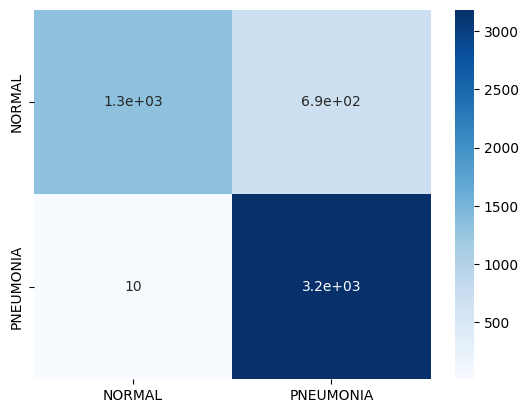

In [35]:
sns.heatmap(cmObject, annot = True, cmap="Blues")

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os

def generate_new_images_from_gan(generator, latent_dim=100, num_classes=2, n_samples=9, frames_per_gif=100, gif_name="gan_sampling_from_noise.gif"):
    """Generate a GIF showing progressive image generation using a GAN generator, starting from pure noise."""
    # Create a directory for storing frames if it doesn't exist
    if not os.path.exists("frames"):
        os.makedirs("frames")
    
    # Step 1: Generate random latent vectors
    z = np.random.uniform(-1, 1, size=(n_samples, latent_dim))  # Final latent space vectors
    labels = np.zeros((n_samples, num_classes))  # Class labels (one-hot encoded)
    labels[:, 0] = 1  # Assuming all belong to class 0 (adjust if needed)
    
    # Generate initial random noise images (same shape as the final image output)
    noise_images = np.random.rand(n_samples, 64, 64, 1)  # Random noise images

    # Initialize the list to store frames for the GIF
    frames = []
    
    # Step 2: Interpolation and frame capture
    for frame_idx, alpha in enumerate(np.linspace(0, 1, frames_per_gif)):
        # Interpolation factor alpha: from 0 (pure noise) to 1 (final generation)
        step_z = z * alpha  # Interpolate latent vectors

        # Step 3: Generate images from the interpolated latent vectors using the GAN's generator
        generated_images = generator.predict([step_z, labels], verbose=0)

        # Step 4: Interpolate between random noise and generated images
        blended_images = (1 - alpha) * noise_images + alpha * generated_images

        # Step 5: Normalize and reshape images for visualization
        normalized_images = (blended_images - np.min(blended_images)) / (np.max(blended_images) - np.min(blended_images)) * 255
        normalized_images = normalized_images.astype(np.uint8)  # Convert to uint8 format

        # Step 6: Create a 3x3 grid of the generated images
        fig, axes = plt.subplots(3, 3, figsize=(6, 6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(normalized_images[i, :, :, 0], cmap='gray')
            ax.axis('off')  # Hide axes for a clean visualization

        # Adjust subplot layout and remove spaces between subplots
        plt.subplots_adjust(wspace=0, hspace=0)

        # Save the frame
        frame_filename = f'frames/frame_{frame_idx}.png'
        plt.savefig(frame_filename, bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # Close the figure to free memory
        frames.append(frame_filename)

    # Step 7: Convert the frames into a GIF
    images = []
    for frame in frames:
        images.append(imageio.imread(frame))  # Read each frame
    imageio.mimsave(gif_name, images, duration=0.5)  # Save GIF with frame duration of 0.5 seconds
    
    # Cleanup: Remove temporary frame files
    for frame in frames:
        os.remove(frame)
    os.rmdir("frames")

    print(f"GIF saved as {gif_name}")


# Generate GIF from the GAN generator
generate_new_images_from_gan(G, latent_dim=100, num_classes=2, n_samples=9, frames_per_gif=100, gif_name='gan_generation_from_noise.gif')


GIF saved as gan_generation_from_noise.gif
